## Variational AutoEncoders (VAE) ##

In this notebook, we will cover VAEs to learn the distribution of the FashionMNIST and be able to generate clothe variation.

<img src="../figures/VAE.png" width="600">

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision.transforms import ToTensor, Lambda, Grayscale, Compose, Resize, Scale
from torchvision import transforms
from torchvision.datasets import MNIST, KMNIST, FashionMNIST, ImageFolder
from matplotlib import pyplot as plt
import torchvision.utils as vutils

import numpy as np

In [2]:
IMG_WIDTH = 28
IMG_HEIGHT = 28
batch_size = 256
IMGS_TO_VISUALIZE = 4
d = 20 # Latent Dimension
dataset_path = "../data" # Change to your FashionMnist data path!

# Set random seeds for reproducibility

torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Displaying routine
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, IMG_HEIGHT, IMG_WIDTH)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, IMG_HEIGHT, IMG_WIDTH)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [5]:
# Define data loading step
# kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    FashionMNIST(dataset_path, train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    FashionMNIST(dataset_path, train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

In [6]:
class VAE(nn.Module):
    def __init__(self, img_width, img_height):
        super().__init__()
        
        self.img_width = img_width
        self.img_height = img_height

        self.encoder = nn.Sequential(
            nn.Linear(img_width * img_height, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, img_width * img_height),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        
        x = x.view(-1, self.img_width * self.img_height) # Flatten in case it is not already
        
        mu_logvar = self.encoder(x)        
        mu_logvar = mu_logvar.view(-1, 2, d) # divide dimensions to get mu and variance # [batch_size, d * 2] -> [batch_size, 2, d] 
        mu = mu_logvar[:, 0, :] # mean
        logvar = mu_logvar[:, 1, :] # variance
        
        z = self.reparameterise(mu, logvar) # create the latent representation based on mu and variance
        
        return self.decoder(z), mu, logvar

In [7]:
IMG_WIDTH = 28
IMG_HEIGHT = 28

model = VAE(IMG_WIDTH,IMG_HEIGHT).to(device)

In [8]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

#### Custom Loss Function ####

We define a custom loss function for the VAE, since we need to accommodate for the reconstruction loss and the KL-Divergence Loss

In [9]:
# Reconstruction + KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar):
    
    # Reconstruction loss
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, IMG_WIDTH * IMG_HEIGHT), reduction='sum'
    )
    
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #KL-Divergence loss

    return BCE + KLD

In [10]:
def train(num_epochs = 5):
    
    imgs = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
        
        # Testing
    
        with torch.no_grad():
            model.eval()
            test_loss = 0
            for x, _ in test_loader:
                x = x.to(device)
                # ===================forward=====================
                x_hat, mu, logvar = model(x)
                test_loss += loss_function(x_hat, x, mu, logvar).item()
                
        # ===================log========================
        test_loss /= len(test_loader.dataset)
        print(f'====> Test set loss: {test_loss:.4f}')
          
        # Print imgs if wanted
        x_hat = x_hat.view(-1, 1, IMG_HEIGHT, IMG_WIDTH)
        imgs.append(torch.cat([x[:IMGS_TO_VISUALIZE], x_hat[:IMGS_TO_VISUALIZE]], dim = 0))
    
    concat_imgs = torch.cat([tens for tens in imgs])
    return mu, logvar, x, concat_imgs

====> Epoch: 0 Average loss: 302.9165
====> Test set loss: 267.3589
====> Epoch: 1 Average loss: 263.7855
====> Test set loss: 259.2494
====> Epoch: 2 Average loss: 255.9704
====> Test set loss: 250.0502
====> Epoch: 3 Average loss: 251.7439
====> Test set loss: 246.8468
====> Epoch: 4 Average loss: 249.2506
====> Test set loss: 245.2944
====> Epoch: 5 Average loss: 247.5517
====> Test set loss: 243.2295
====> Epoch: 6 Average loss: 246.4128
====> Test set loss: 241.8493
====> Epoch: 7 Average loss: 245.4741
====> Test set loss: 241.0808
====> Epoch: 8 Average loss: 244.8158
====> Test set loss: 240.3306
====> Epoch: 9 Average loss: 244.2507
====> Test set loss: 240.3369
====> Epoch: 10 Average loss: 243.8268
====> Test set loss: 240.5618
====> Epoch: 11 Average loss: 243.4178
====> Test set loss: 239.3430
====> Epoch: 12 Average loss: 243.0272
====> Test set loss: 239.1625
====> Epoch: 13 Average loss: 242.7395
====> Test set loss: 238.5652
====> Epoch: 14 Average loss: 242.5114
====>

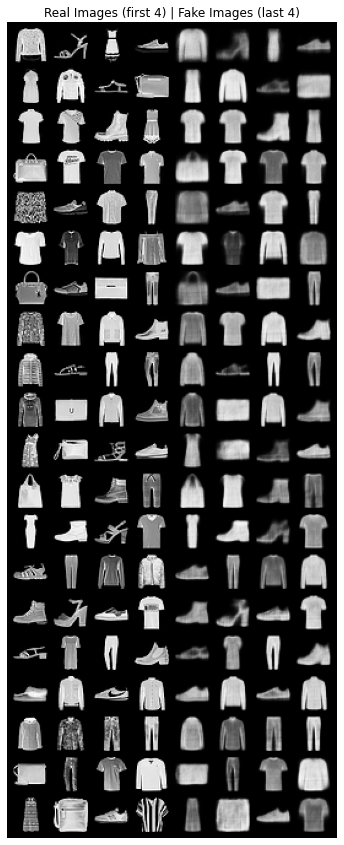

In [11]:
mu, logvar, x, imgs = train(20) # Get mu, variance, and last input to the network to test after!

# Plot what was generated and what 

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images (first 4) | Fake Images (last 4)")
plt.imshow(np.transpose(vutils.make_grid(imgs, padding=5, normalize=True, nrow=IMGS_TO_VISUALIZE * 2).cpu(),(1,2,0))) 

-------------------------

## Now try the following ##

- Adapt VAE to a different dataset
- Interpolate between latent space points